# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

# Data

In [3]:
df = pd.read_csv('data/fpl_fbref_players.csv')

In [4]:
info = ["Name"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [5]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

In [6]:
df.shape

(6104, 11)

In [7]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')
df = grouped.filter(lambda x: len(x) >= 15)

In [8]:
df.shape

(4080, 11)

In [9]:
last_names = df["Name"].unique()

In [10]:
# for p in df["Name"].unique():
#     print (p, df[df["Name"] == p].shape)

In [11]:
# shifting
# df['FPL'] = df['FPL'].shift(-1)
# test_row = df[-1]
# df = df[:-1]

# DF to DataLoader

In [12]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        # print(idx)
        name = self.names[idx]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name].drop(columns=["Name"]).values[:, :-1]
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[-1, -1])
        # print(type(target))
        return features, target

In [13]:
dataset = PandasDataset(df)
dataset.__getitem__(3)

(array([[90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [90. ,  1. ,  2. ,  1. ,  0.1,  0.1,  0. ,  0. ,  0. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
        [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  1. ,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]],
       dtype=float32),
 2.0)

In [14]:
batch_size = 16

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [16]:
next(iter(dataloader))[1]

tensor([2., 2., 2., 2., 1., 2., 5., 2., 3., 2., 2., 2., 2., 2., 1., 1.])

# LSTM Model

In [17]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [18]:
len(dataloader)

17

In [19]:
torch.transpose(next(iter(dataloader))[0], 0, 1).shape

torch.Size([15, 16, 9])

In [20]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loop

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [41]:
num_epochs = 100
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2)
        # print("INPUTS", inputs.shape)
        # print("TARGETS", targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs).flatten()
        # print("OUTPUTS", outputs.shape)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

Epoch 0 Loss: 0.11081814985064899
Epoch 5 Loss: 0.07780303882763666
Epoch 10 Loss: 0.14101644528701024
Epoch 15 Loss: 0.14212592154303016
Epoch 20 Loss: 0.05873253393699141
Epoch 25 Loss: 0.0533508222331019
Epoch 30 Loss: 0.0990392800201388
Epoch 35 Loss: 0.12727357584106572
Epoch 40 Loss: 0.03846530786112828
Epoch 45 Loss: 0.0384687438935918
Epoch 50 Loss: 0.036308416822815645
Epoch 55 Loss: 0.03725725248017732
Epoch 60 Loss: 0.04402176624930957
Epoch 65 Loss: 0.04344760862124317
Epoch 70 Loss: 0.08213718224535971
Epoch 75 Loss: 0.15595679532955675
Epoch 80 Loss: 0.07668501341386753
Epoch 85 Loss: 0.06533499845467947
Epoch 90 Loss: 0.048643513637430524
Epoch 95 Loss: 0.027378796517629835


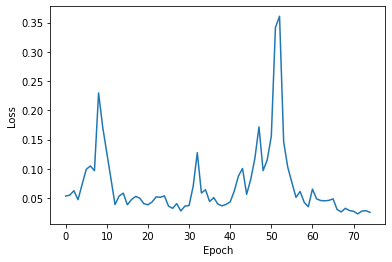

In [42]:
plt.plot(loss_history[25:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [50]:
index = 0
predictions = []
for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    outputs = net(inputs)
    for output in outputs:
        name = last_names[index]
        points = round(output.item(), 2)
        predictions.append([name, points])
        index += 1

In [53]:
pd.DataFrame(predictions, columns=["Name", "Points"]).sort_values(by=["Points"], ascending = False)

,Name,Points
131,Harry-Kane,12.88
244,Ivan-Toney,11.31
240,Marcus-Tavernier,11.10
228,Luke-Shaw,9.02
172,Aleksandar-Mitrovic,8.13
...,...,...
248,Leandro-Trossard,0.96
56,Marc-Cucurella,0.96
94,Conor-Gallagher,0.96
69,Moussa-Djenepo,0.96
